<a href="https://colab.research.google.com/github/maticortesr/data-science-portfolio/blob/master/Text_Summarization_TF2_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Abstractive Text Sumarization**

Dataset: Amazon Reviews (Kaggle) <br />
Tools: Python 3, Tensorflow 2, NLTK, py-rouge (scoring) <br />
Approach: Encoder-Decoder Arquitecture with attention and pre-trained embeddings (GloVe) <br />
Encoder: Embedding Layer and RRN Layer (LSTM) <br />
Decoder: Embedding Layer, LSTM cell, Attention mechanism (Luong), Dense Layer <br />
Inference: Beam Search (beam=3) <br />
Scoring: Rouge



In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=db702371d07aa0dbd3bd229a08454b837a1e6cd76bd6413f2fe51be228cd0126
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.3 GB  | Proc size: 835.9 MB
GPU RAM Free: 16015MB | Used: 265MB | Util   2% | Total 16280MB


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks'

Mounted at /content/gdrive


In [0]:
%tensorflow_version 2.x
!pip install tensorflow-addons

In [0]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maticortes","key":"5e7b3bf8cc4cd143ecc8f9ab70a23983"}'}

In [0]:
'''
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json '''

-rw-r--r-- 1 root root 66 Dec  7 20:08 kaggle.json


In [0]:
#!kaggle datasets download -d snap/amazon-fine-food-reviews

 95% 230M/242M [00:01<00:00, 129MB/s]
100% 242M/242M [00:01<00:00, 141MB/s]


In [0]:
#!unzip "*.zip"

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [0]:
#!mv Reviews.csv  gdrive/My\ Drive/Colab\ Notebooks/datasets/

In [0]:
import numpy as np
import pandas as pd 
import re
import os
import itertools
import time

import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds

print(tf.__version__)

from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

2.0.0


In [0]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [0]:
#Total number of lines on csv
#!wc -l gdrive/My\ Drive/Colab\ Notebooks/datasets/Amazon_reviews.csv

In [0]:
data=pd.read_csv(os.path.join(base_dir ,"datasets","Amazon_reviews.csv"),nrows=100000)

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [0]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [0]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [0]:
cleaned_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [0]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

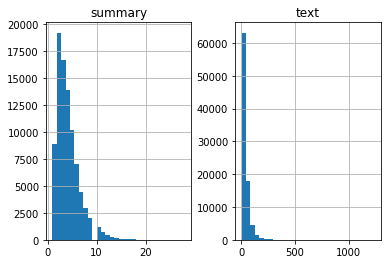

In [0]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [0]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9449242227026293


In [0]:
max_text_len=100
max_summary_len=10

In [0]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [0]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

Tokenization

In [0]:
MAX_NUM_WORDS = 20000

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
x_tokenizer.fit_on_texts(list(x_tr))

In [0]:
#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [0]:
x_voc

20001

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=5000)   
y_tokenizer.fit_on_texts(list(y_tr))

In [0]:
#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [0]:
y_tokenizer.num_words + 1

5001

Saving Assets

In [0]:
import pickle as pkl
x_path = os.path.join(base_dir ,"summary_amazon_tf2_glove", "x_tokenizer.pkl")
with open(x_path, "wb") as f:
    pkl.dump(x_tokenizer, f) 

In [0]:
y_path  = os.path.join(base_dir ,"summary_amazon_tf2_glove", "y_tokenizer.pkl")
with open(y_path, "wb") as f:
    pkl.dump(y_tokenizer, f) 

In [0]:
x_voc_path = os.path.join(base_dir ,"summary_amazon_tf2_glove", "x_voc.pkl")
with open(x_voc_path, "wb") as f:
    pkl.dump(x_voc, f) 

In [0]:
y_voc_path = os.path.join(base_dir ,"summary_amazon_tf2_glove", "y_voc.pkl")
with open(y_voc_path, "wb") as f:
    pkl.dump(y_voc, f) 

Loading Assets

In [0]:
import pickle as pkl
with open(os.path.join(base_dir ,"summary_amazon_tf2_glove", "x_tokenizer.pkl"), "rb") as f:
    x_tokenizer = pkl.load(f)

with open(os.path.join(base_dir ,"summary_amazon_tf2_glove", "y_tokenizer.pkl"), "rb") as f:
    y_tokenizer = pkl.load(f)

with open(os.path.join(base_dir ,"summary_amazon_tf2_glove", "x_voc.pkl"), "rb") as f:
    x_voc = pkl.load(f)

with open(os.path.join(base_dir ,"summary_amazon_tf2_glove", "y_voc.pkl"), "rb") as f:
    y_voc = pkl.load(f)

with open(os.path.join(base_dir ,"summary_amazon_tf2_glove", "embedding_matrix.pkl"), "rb") as f:
    embedding_matrix = pkl.load(f)

Modeling

In [0]:
BATCH_SIZE = 64
#BUFFER_SIZE = len(x_tr)
#steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dims = 100
rnn_units = 512 #1024
dense_units = 512 # 1024
Dtype = tf.float32   #used to initialize DecoderCell Zero state

In [0]:
print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(os.path.join(base_dir ,"summary_multi_news_tf2_attention_glove"), 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [0]:
print('Preparing embedding matrix.')
word_index = x_tokenizer.word_index

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

Preparing embedding matrix.


In [0]:
print('Preparing embedding matrix.')
embedding_matrix = np.zeros((num_words, embedding_dims))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
#Saving Embedding matrix
embedding_matrix_path = os.path.join(base_dir ,"summary_amazon_tf2_glove", "embedding_matrix.pkl")
with open(embedding_matrix_path, "wb") as f:
    pkl.dump(embedding_matrix_path, f) 

In [0]:
embedding_matrix.shape

(20000, 100)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
example_X, example_Y = next(iter(dataset))
print(example_X.shape) 
print(example_Y.shape)  

(64, 100)
(64, 10)


In [0]:
dataset_test = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
example_X, example_Y = next(iter(dataset))
print(example_X.shape) 
print(example_Y.shape)

(64, 100)
(64, 10)


In [0]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units,embedding_matrix ):
        super().__init__()
        self.encoder_embedding = tf.keras.layers.Embedding( input_dim=input_vocab_size,
                                                           embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                           output_dim=embedding_dims, trainable=False
                                                           )
        self.encoder_rnnlayer = tf.keras.layers.LSTM(rnn_units,return_sequences=True, 
                                                     return_state=True )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab_size,
                                                           output_dim=embedding_dims) 
        self.dense_layer = tf.keras.layers.Dense(output_vocab_size)
        self.decoder_rnncell = tf.keras.layers.LSTMCell(rnn_units)
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[max_text_len])
        self.rnn_cell =  self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler= self.sampler,
                                                output_layer=self.dense_layer)

    def build_attention_mechanism(self, units,memory, memory_sequence_length):
        return tfa.seq2seq.LuongAttention(units, memory = memory, 
                                          memory_sequence_length=memory_sequence_length)
        #return tfa.seq2seq.BahdanauAttention(units, memory = memory, memory_sequence_length=memory_sequence_length)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size ):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism,
                                                attention_layer_size=dense_units)
        return rnn_cell
    
    def build_decoder_initial_state(self, batch_size, encoder_state,Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 
        return decoder_initial_state



#encoderNetwork = EncoderNetwork(x_voc,embedding_dims, rnn_units, embedding_matrix)
encoderNetwork = EncoderNetwork(num_words,embedding_dims, rnn_units, embedding_matrix)
decoderNetwork = DecoderNetwork(y_voc,embedding_dims, rnn_units)


In [0]:
optimizer = tf.keras.optimizers.Adam()

In [0]:
def loss_function(y_pred, y):
   
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    #skip loss calculation for padding sequences i.e. y = 0 
    #[ <start>,How, are, you, today, 0, 0, 0, 0 ....<end>]
    #[ 1, 234, 3, 423, 3344, 0, 0 ,0 ,0, 2 ]
    # y is a tensor of [batch_size,Ty] . Create a mask when [y=0]
    # mask the loss when padding sequence appears in the output sequence
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss


In [0]:
decoderNetwork.attention_mechanism.memory_initialized

False

In [0]:
def train_step(input_batch, output_batch,encoder_initial_cell_state):
    #initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state =encoder_initial_cell_state)

        #[last step activations,last memory_state] of encoder passed as input to decoder Network
        
         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore <end>
        #compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore <start>


        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)
        
        #BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[max_summary_len-1])

        logits = outputs.rnn_output
        #Calculate loss

        loss = loss_function(logits, decoder_output)

    #Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    #grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

Training

In [0]:
checkpointdir = os.path.join(base_dir ,"summary_amazon_tf2_glove")

In [0]:
checkpointdir = os.path.join(base_dir ,"summary_amazon_tf2_glove")
chkpoint_prefix = os.path.join(checkpointdir, "chkpoint")
if not os.path.exists(checkpointdir):
    os.mkdir(checkpointdir)

checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoderNetwork = encoderNetwork, 
                                 decoderNetwork = decoderNetwork)

try:
    status = checkpoint.restore(tf.train.latest_checkpoint(checkpointdir))
    print("Checkpoint found at {}".format(tf.train.latest_checkpoint(checkpointdir)))
except:
    print("No checkpoint found at {}".format(checkpointdir))

Checkpoint found at /content/gdrive/My Drive/Colab Notebooks/summary_amazon_tf2_glove/chkpoint-63


In [0]:
#RNN LSTM hidden and memory state initializer
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]

In [0]:
epochs = 5
for i in range(1, epochs+1):
    start = time.time()
    loss_list = []
    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0


    for ( batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
        loss_list.append(batch_loss.numpy())
        if (batch+1)%300 == 0:
            print("total loss: {} epoch {} batch {} ".format(batch_loss.numpy(), i, batch+1))
    checkpoint.save(file_prefix = chkpoint_prefix)
    print('Time taken for 1 epoch {} min'.format((time.time() - start)/60))
    print( 'Average Epoch loss: ', np.mean(loss_list))
    print('\n')

In [0]:
decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 

In [0]:
decoder_embedding_matrix = tf.train.load_variable(checkpointdir, 'decoderNetwork/decoder_embedding/embeddings/.ATTRIBUTES/VARIABLE_VALUE')
print(decoder_embedding_matrix.shape)

(5001, 100)


In [0]:
def get_sequences_from_input(text):  
  cleaned_inf_text = text_cleaner(text,0)
  inf_text = np.array([cleaned_inf_text])
  
  #convert text sequences into integer sequences
  inf_tr_seq = x_tokenizer.texts_to_sequences(inf_text)
  
  #padding zero upto maximum length
  inf_vec = pad_sequences(inf_tr_seq,  maxlen=max_text_len, padding='post')
  
  return inf_vec

In [0]:
def decode_from_text(inference_text):
  inp = tf.convert_to_tensor(get_sequences_from_input(inference_text))
  #print(inp.shape)
  inference_batch_size = get_sequences_from_input(inference_text).shape[0]
  encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                                tf.zeros((inference_batch_size, rnn_units))]
  encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
  a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                  initial_state =encoder_initial_cell_state)

  start_tokens = tf.fill([inference_batch_size],y_tokenizer.word_index['sostok'])
  #print(start_tokens)
  end_token = y_tokenizer.word_index['eostok']

  greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
  #finished,start_inputs = greedy_sampler.initialize(decoder_embedding_matrix,start_tokens,end_token)
  #print(finished.shape, start_inputs.shape)

  decoder_input = tf.expand_dims([y_tokenizer.word_index['sostok']]* inference_batch_size,1)
  decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

  decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, sampler = greedy_sampler,
                                              output_layer=decoderNetwork.dense_layer)
  decoderNetwork.attention_mechanism.setup_memory(a)
  #pass [ last step activations , encoder memory_state ] as input to decoder for LSTM
  decoder_initial_state = decoderNetwork.build_decoder_initial_state(inference_batch_size,
                                                                    encoder_state=[a_tx, c_tx],
                                                                    Dtype=tf.float32)
    # Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
  # One heuristic is to decode up to two times the source sentence lengths.
  maximum_iterations = tf.round(tf.reduce_max(max_text_len) * 2)

  #initialize inference decoder

  (first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                              start_tokens = start_tokens,
                              end_token=end_token,
                              initial_state = decoder_initial_state)
  #print( first_finished.shape)
  inputs = first_inputs
  state = first_state  
  predictions = np.empty((inference_batch_size,0), dtype = np.int32)                                                                             
  for j in range(maximum_iterations):
      outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
      inputs = next_inputs
      state = next_state
      outputs = np.expand_dims(outputs.sample_id,axis = -1)
      if y_tokenizer.index_word[outputs[0][0]] == 'eostok':
        return predictions      
      predictions = np.append(predictions, outputs, axis = -1)

In [0]:
def idx_to_text(predictions):
  result = ''
  for i in range(len(predictions)):
    line = predictions[i,:]
    seq = list(itertools.takewhile( lambda index: index !=2, line))
    return " ".join( [y_tokenizer.index_word[w] for w in seq])

In [0]:
test_data=pd.read_csv(os.path.join(base_dir ,"datasets","Amazon_reviews.csv"),skiprows=100000,nrows=10)

In [0]:
test_data.iloc[:,-1][9]

"the deliver is on time. And the noodle's are great. But the pack is quite large so I probably will finish it in a few months."

In [0]:
test_data.iloc[:,-2][9]

'nong shim shin noodle is my Favorite instant noodle'

In [0]:
inference_text = test_data.iloc[:,-1][9]

In [0]:
idx_to_text(decode_from_text(inference_text))

'great replacement'

In [0]:
def decode_from_text_beam(inference_text, beam_width=3):
  length_penalty = 1.0
  #use with scope /cpu:0 for inferencing
  #restore from latest checkpoint for inferencing

  inp = tf.convert_to_tensor(get_sequences_from_input(inference_text))
  #print(inp.shape)
  inference_batch_size = get_sequences_from_input(inference_text).shape[0]
  encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                                tf.zeros((inference_batch_size, rnn_units))]
  encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
  a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                  initial_state =encoder_initial_cell_state)

  start_tokens = tf.fill([inference_batch_size],y_tokenizer.word_index['sostok'])
  #print(start_tokens)
  end_token = y_tokenizer.word_index['eostok']



  decoder_input = tf.expand_dims([y_tokenizer.word_index['sostok']]* inference_batch_size,1)
  decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)


  #From official documentation
  #NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:

  #The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
  #The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
  #The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.
  encoder_memory = tfa.seq2seq.tile_batch(a, beam_width)
  decoderNetwork.attention_mechanism.setup_memory(encoder_memory)
  #print("beam_with * [batch_size, max_text_len, rnn_units] :  3 * [2, max_text_len, rnn_units]] :", encoder_memory.shape)
  #set decoder_inital_state which is an AttentionWrapperState considering beam_width
  decoder_initial_state = decoderNetwork.rnn_cell.get_initial_state(batch_size = inference_batch_size* beam_width,dtype = Dtype)
  encoder_state = tfa.seq2seq.tile_batch([a_tx, c_tx], multiplier=beam_width)
  decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 

  decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoderNetwork.rnn_cell,beam_width=beam_width,
                                                  output_layer=decoderNetwork.dense_layer, length_penalty_weight=length_penalty)


  # Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
  # One heuristic is to decode up to two times the source sentence lengths.
  maximum_iterations = tf.round(tf.reduce_max(max_text_len) * 2)

  #initialize inference decoder

  (first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                              start_tokens = start_tokens,
                              end_token=end_token,
                              initial_state = decoder_initial_state)
  #print( first_finished.shape)
  #print("\nfirst_inputs returns the same decoder_input i.e. embedding of  <start> :",first_inputs.shape)

  inputs = first_inputs
  state = first_state  
  predictions = np.empty((inference_batch_size, beam_width,0), dtype = np.int32)
  beam_scores =  np.empty((inference_batch_size, beam_width,0), dtype = np.float32)                                                                            
  for j in range(maximum_iterations):
      beam_search_outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
      inputs = next_inputs
      state = next_state
      outputs = np.expand_dims(beam_search_outputs.predicted_ids,axis = -1)
      scores = np.expand_dims(beam_search_outputs.scores,axis = -1)
      #print(outputs.shape)
      if y_tokenizer.index_word[outputs[0][0][0]] == 'eostok':
        return predictions, beam_scores
      predictions = np.append(predictions, outputs, axis = -1)
      beam_scores = np.append(beam_scores, scores, axis = -1)
  print(predictions.shape)  
  print(beam_scores.shape)
  return predictions, beam_scores                                                                             

In [0]:
def idx_to_text_beam(predictions,beam_scores):
  final_summaries = []
  final_scores = []
  for i in range(len(predictions)):
    output_beams_per_sample = predictions[i,:,:]
    score_beams_per_sample = beam_scores[i,:,:]
    for beam, score in zip(output_beams_per_sample,score_beams_per_sample) :
        seq = list(itertools.takewhile( lambda index: index !=2, beam))
        score_indexes = np.arange(len(seq))
        beam_score = score[score_indexes].sum()  
        final_summaries.append(" ".join( [y_tokenizer.index_word[w] for w in seq]))
        final_scores.append(beam_score)
    max_score_idx = final_scores.index(max(final_scores))
    return final_summaries[max_score_idx]

In [0]:
inference_text = ''' Really good. Bone sucking sauce. Light, yet effective bbq flavor. Yum.  '''

In [0]:
idx_to_text_beam(decode_from_text_beam(inference_text)[0],decode_from_text_beam(inference_text)[1] )

'really but'

In [0]:
idx_to_text(decode_from_text(inference_text))

'great sauce that should be'

Testing

In [0]:
count = 0
records_test = []
n_sample = 2000

In [0]:
test_data=pd.read_csv(os.path.join(base_dir ,"datasets","Amazon_reviews.csv"),skiprows=100000,nrows=n_sample)

In [0]:
records_test = list(zip(test_data.iloc[:,-1],test_data.iloc[:,-2]))

In [0]:
n_test = 2000
original_text = []
summaries = []
true_summaries = []

In [0]:
np.random.seed(seed=0)
records_test_idx = np.random.random_integers(low=0,high=len(records_test),size=n_test)

In [0]:
for i in range(len(records_test)):
  true_summaries.append(records_test[i][1])
  original_text.append(records_test[i][0])
  temp_summ = idx_to_text_beam(decode_from_text_beam(records_test[i][0])[0],decode_from_text_beam(records_test[i][0])[1] )
  summaries.append(temp_summ)

In [0]:
s = 1000
print(original_text[s])
print('---------------------\n')
print(true_summaries[s])
print('---------------------\n')
print(summaries[s])

Man this stuff is spicy and tastes great!!!  I like spicy stuff and this is probably the best I have had out of package.
---------------------

HOLY COW!!! GOOD STUFF
---------------------

bbq bbq


In [0]:
true_summaries_str = [str(x) for x in true_summaries]
summaries_str = [str(x) for x in summaries]

Rougue Scoring

In [0]:
!pip install py-rouge
nltk.download('punkt')

     |████████████████████████████████| 61kB 1.9MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import rouge


def prepare_results(m, p, r, f):
    return '\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(m, 'P', 100.0 * p, 'R', 100.0 * r, 'F1', 100.0 * f)


#for aggregator in ['Avg', 'Best', 'Individual']:
for aggregator in ['Avg']:

    print('Evaluation with {}'.format(aggregator))
    apply_avg = aggregator == 'Avg'
    apply_best = aggregator == 'Best'

    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=apply_avg,
                           apply_best=apply_best,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

    scores = evaluator.get_scores(summaries_str, true_summaries_str)

    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        if not apply_avg and not apply_best: # value is a type of list as we evaluate each summary vs each reference
            for hypothesis_id, results_per_ref in enumerate(results):
                nb_references = len(results_per_ref['p'])
        else:
            print(prepare_results(metric, results['p'], results['r'], results['f']))
    print()

Evaluation with Avg
	rouge-1:	P: 25.95	R: 22.53	F1: 23.27
	rouge-2:	P: 16.21	R: 14.97	F1: 15.30
	rouge-3:	P:  9.07	R:  8.46	F1:  8.61
	rouge-4:	P:  4.86	R:  4.49	F1:  4.59
	rouge-l:	P: 26.84	R: 23.67	F1: 24.47
	rouge-w:	P: 25.46	R: 17.82	F1: 20.06

